# Tutorial 01: Python Wrapper

The collision checker provides you the functionality to check if basic geometric shapes and groups of shapes collide. Currently several basic shapes are available: axis-aligned rectangles (pycrcc.RectAABB), oriented rectangles (pycrcc.RectOBB), triangles (pycrcc.Triangle), circles (pycrcc.Circle), and polygons (pycrcc.Polygon). The most basic intersection test can be performed between these primitive shapes.

## 1. Creating Basic Geometric Shapes

We start with creating a set of basic shapes. We therefore need to import the Python wrapper ‘pycrcc’.

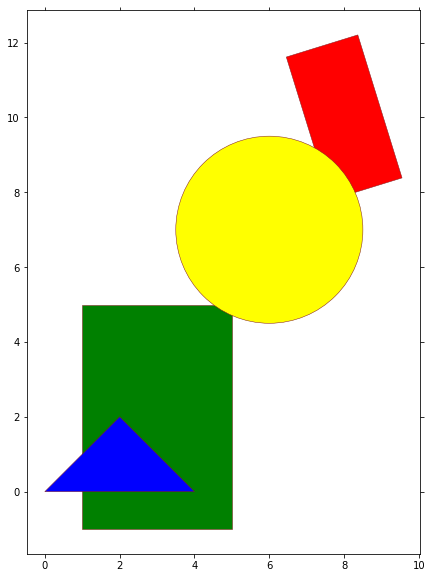

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import commonroad_dc.pycrcc as pycrcc
from commonroad.visualization.mp_renderer import MPRenderer

# Axis-aligned rectangle with width/2, height/2, x-position , y-position
aabb = pycrcc.RectAABB(2.0, 3.0, 3.0, 2.0)

# Oriented rectangle with width/2, height/2, orientation, x-position , y-position
obb = pycrcc.RectOBB(1.0, 2.0, 0.3, 8.0, 10.0)

# Circle with radius, x-position , y-position
circ = pycrcc.Circle(2.5, 6.0, 7.0)

# Triangle with vertices (x1, y1), (x2, y2), and (x3, y3)
tri = pycrcc.Triangle(0.0, 0.0, 4.0, 0.0, 2.0, 2.0)

rnd = MPRenderer(figsize=(10, 10))
aabb.draw(rnd, draw_params={'facecolor': 'green'})
obb.draw(rnd, draw_params={'facecolor': 'red'})
circ.draw(rnd, draw_params={'facecolor': 'yellow'})
tri.draw(rnd, draw_params={'facecolor': 'blue'})
rnd.render()


In order to create a polygon, we need to define several components: the vertices of the outer boundary, the vertices of holes, and a triangle mesh which is used for collision checks. We can therefore use *Python Triangle*, which is a python wrapper around Jonathan Richard Shewchuk’s Triangle library.

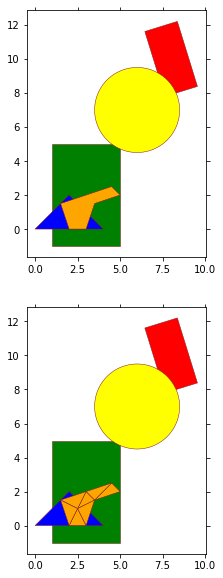

In [2]:
import triangle

# define the vertices of the outer boundary, we assume that we have no holes
vertices = [[2.0, 0.0], [3.0, 0.0], [3.5, 1.5], [5.0, 2.0], [4.5, 2.5], [1.5, 1.5]]
# triangulate the polygon
number_of_vertices = len(vertices)
segments = list(zip(range(0, number_of_vertices-1), range(1, number_of_vertices)))
segments.append((0, number_of_vertices-1))
triangles = triangle.triangulate({'vertices': vertices, 'segments': segments}, opts='pqS2.4')
# convert all triangles to pycrcc.Triangle
mesh = list()
for t in triangles['triangles']:
    v0 = triangles['vertices'][t[0]]
    v1 = triangles['vertices'][t[1]]
    v2 = triangles['vertices'][t[2]]
    mesh.append(pycrcc.Triangle(v0[0], v0[1],
                                v1[0], v1[1],
                                v2[0], v2[1]))
# create the polygon with the vertices of the outer boundary, the holes, and the triangle mesh
polygon = pycrcc.Polygon(vertices, list(), mesh)

# draw the polygon and its triangle mesh
plt.figure(figsize=(10, 10))
plt.subplot(211)
rnd = MPRenderer()
aabb.draw(rnd, draw_params={'facecolor': 'green'})
obb.draw(rnd, draw_params={'facecolor': 'red'})
circ.draw(rnd, draw_params={'facecolor': 'yellow'})
tri.draw(rnd, draw_params={'facecolor': 'blue'})
polygon.draw(rnd, draw_params={'facecolor': 'orange', 'draw_mesh': False})
rnd.render()


plt.subplot(212)
rnd2 = MPRenderer()
aabb.draw(rnd2, draw_params={'facecolor': 'green'})
obb.draw(rnd2, draw_params= {'facecolor': 'red'})
circ.draw(rnd2, draw_params={'facecolor': 'yellow'})
tri.draw(rnd2, draw_params={'facecolor': 'blue'})
rnd2.draw_list(mesh, draw_params={'facecolor': 'orange', 'draw_mesh': False})
rnd2.render()


## 2: Performing Collision Checks Between Basic Shapes 

Collision queries can be conducted using the function ‘collide’:

In [3]:
print('Collision between OBB and AABB: ', obb.collide(aabb))
print('Collision between AABB and Circle: ', aabb.collide(circ))
print('Collision between Circle and OBB:  ', circ.collide(obb))
print('Collision between Triangle and AABB:  ', tri.collide(aabb))
print('Collision between Polygon and Triangle: ', polygon.collide(tri))
print('Collision between Polygon and Circle: ', polygon.collide(circ))

Collision between OBB and AABB:  False
Collision between AABB and Circle:  True
Collision between Circle and OBB:   True
Collision between Triangle and AABB:   True
Collision between Polygon and Triangle:  True
Collision between Polygon and Circle:  False


## 3: Creating Groups of Shapes

Several basic shapes can be grouped into one collision object using the class ShapeGroup. Collision checks can be performed similiar to basic shapes.

Collision between Circle and Shapegroup 1:  True
Collision between Shapegroup 1 and Shapegroup 2:  True


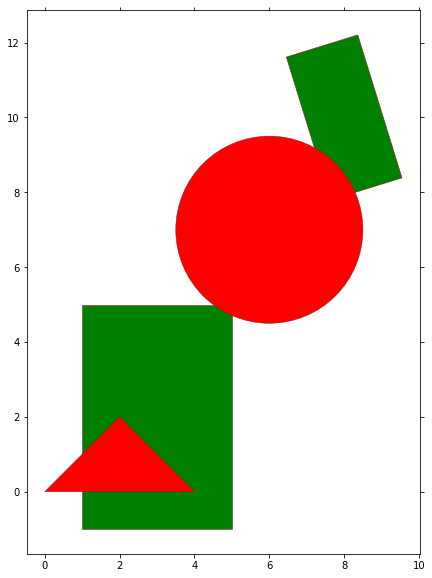

In [4]:
# create two shape groups
sg_1 = pycrcc.ShapeGroup()
sg_1.add_shape(obb)
sg_1.add_shape(aabb)

sg_2 = pycrcc.ShapeGroup()
sg_2.add_shape(circ)
sg_2.add_shape(tri)

print('Collision between Circle and Shapegroup 1: ', circ.collide(sg_1))
print('Collision between Shapegroup 1 and Shapegroup 2: ', sg_1.collide(sg_2))

rnd = MPRenderer(figsize=(10, 10))
sg_1.draw(rnd, draw_params={'facecolor': 'green'})
sg_2.draw(rnd, draw_params={'facecolor': 'red'})
rnd.render()

## 4: Time-variant Obstacles

So far, we have only considered static objects. We can also create time-varying obstacles. Note that the collision checks are only performed at discrete points in time k.

Collision between time-varying obstacle tvo_1 and tvo_2:  True


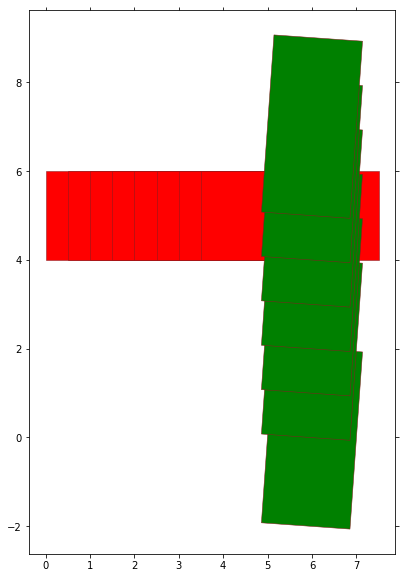

In [5]:
# create a new time-variant collision objects which starts at time step 1
tvo_1 = pycrcc.TimeVariantCollisionObject(1)
# we need to add the shape of the object for each time step
tvo_1.append_obstacle(pycrcc.RectOBB(2, 1, 0.0, 2.0, 5)) # time step 1
tvo_1.append_obstacle(pycrcc.RectOBB(2, 1, 0.0, 2.5, 5)) # time step 2
tvo_1.append_obstacle(pycrcc.RectOBB(2, 1, 0.0, 3, 5))   # time step 3
tvo_1.append_obstacle(pycrcc.RectOBB(2, 1, 0.0, 3.5, 5)) # time step 4
tvo_1.append_obstacle(pycrcc.RectOBB(2, 1, 0.0, 4, 5))   # time step 5
tvo_1.append_obstacle(pycrcc.RectOBB(2, 1, 0.0, 4.5, 5)) # time step 6
tvo_1.append_obstacle(pycrcc.RectOBB(2, 1, 0.0, 5, 5))   # time step 7
tvo_1.append_obstacle(pycrcc.RectOBB(2, 1, 0.0, 5.5, 5)) # time step 8

# create a second time-variant collision objects which starts at time step 4
tvo_2 = pycrcc.TimeVariantCollisionObject(4)
tvo_2.append_obstacle(pycrcc.RectOBB(2, 1, 1.5, 6.0, 0)) # time step 4
tvo_2.append_obstacle(pycrcc.RectOBB(2, 1, 1.5, 6.0, 2)) # time step 5
tvo_2.append_obstacle(pycrcc.RectOBB(2, 1, 1.5, 6.0, 3)) # time step 6
tvo_2.append_obstacle(pycrcc.RectOBB(2, 1, 1.5, 6.0, 4)) # time step 7
tvo_2.append_obstacle(pycrcc.RectOBB(2, 1, 1.5, 6.0, 5)) # time step 8
tvo_2.append_obstacle(pycrcc.RectOBB(2, 1, 1.5, 6.0, 6)) # time step 9
tvo_2.append_obstacle(pycrcc.RectOBB(2, 1, 1.5, 6.0, 7)) # time step 10

# Check if both objects collide
print('Collision between time-varying obstacle tvo_1 and tvo_2: ', tvo_1.collide(tvo_2))

rnd = MPRenderer(figsize=(10, 10))
tvo_1.draw(rnd, draw_params={'facecolor': 'red'})
tvo_2.draw(rnd, draw_params={'facecolor': 'green'})
rnd.render()

## 5: Creating a Collision Checker

Several planning algorithms test a large number of candidate trajectories for collisions. These checks must be executed between each trajectory and all obstacles in the environment. The pycrcc.CollisionChecker provides the functionality to manage the set of all obstacles in the environment. After all obstacles are added to pycrcc.CollisionChecker, a collision check query for a trajectory can be called:

Collision with trajectory tvo_2:  True


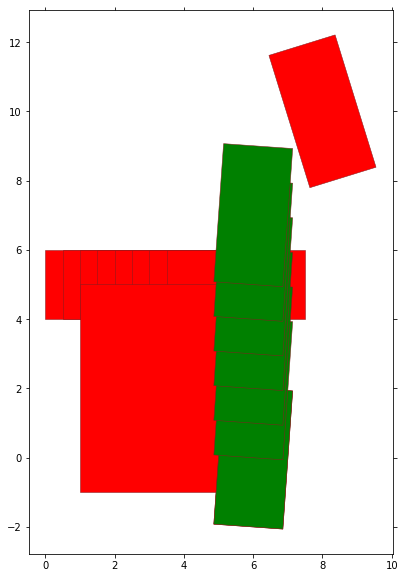

In [6]:
# create a new collision checker
cc = pycrcc.CollisionChecker()
# add all obstacles in the environment
cc.add_collision_object(tvo_1)
cc.add_collision_object(sg_1)
cc.add_collision_object(pycrcc.RectOBB(2, 1, 1.5, 6.0, 0))

print('Collision with trajectory tvo_2: ', cc.collide(tvo_2))

rnd = MPRenderer(figsize=(10, 10))
cc.draw(rnd, draw_params={'facecolor': 'red'})
tvo_2.draw(rnd, draw_params={'facecolor': 'green'})
rnd.render()

Sometimes, it might be necessary to get all obstacles within the collision checker at a specific point in time. This can be done with the function ‘time_slice’:

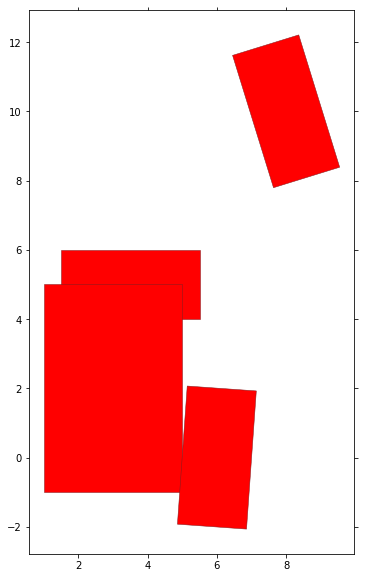

In [7]:
# plot all obstacles at time step 4
rnd = MPRenderer(figsize=(10, 10))
cc.time_slice(4).draw(rnd, draw_params={'facecolor': 'red'})
rnd.render()

## 5: Intersection Between Segments and Obstacles

We can also create a segment and test it for intersections with objects in the environment.

Raytrace, with join
[[1.0, 1.0, 9.27196058403934, 9.27196058403934]]
Raytrace, no join
[[1.0, 1.0, 5.0, 5.0], [8.195582495781316, 8.195582495781316, 4.804417504218684, 4.804417504218684], [9.27196058403934, 9.27196058403934, 7.86461834282844, 7.86461834282844]]


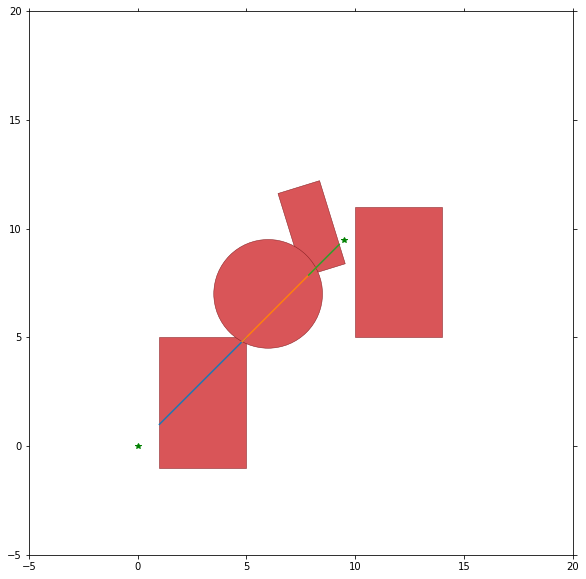

In [8]:
# Axis-aligned rectangle with width/2, height/2, x-position , y-position
aabb_2 = pycrcc.RectAABB(2,3,12,8)

# create collision checker and add obstacles
cc = pycrcc.CollisionChecker()
cc.add_collision_object(obb)
cc.add_collision_object(aabb)
cc.add_collision_object(aabb_2)
cc.add_collision_object(circ)

# segment with start and end point
start = [0, 0]
end = [9.5, 9.5]

print("Raytrace, with join")
intervals = cc.raytrace(start[0], start[1], end[0], end[1], True)
print(intervals)

print("Raytrace, no join")
intervals = cc.raytrace(start[0], start[1], end[0], end[1], False)
print(intervals)

rnd = MPRenderer(figsize=(10, 10))
cc.draw(rnd)
rnd.render()
plt.ylim([-5, 20])
plt.xlim([-5, 20])

# plot start and end point of segment
plt.plot((start[0], end[0]), (start[1], end[1]), '*g', zorder=50)

# plot all intersecting intervals of the segment
for i in intervals:
    plt.plot((i[0], i[2]), (i[1], i[3]), zorder=50)

plt.show()